<a href="https://colab.research.google.com/github/youngchul-sung/three-minutes-keras/blob/master/ex8_1_unet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

#######################################################################################
# unet_conv_cifar10rgb_mc.py
# Convlutional Layer UNET with RGB Cifar10 dataset and Class with Keras Model approach
#######################################################################################
#import matplotlib
#matplotlib.use("TkAgg")

###########################
# AE 모델링
###########################
import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras import models, backend, datasets, optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, \
    UpSampling2D, BatchNormalization, Concatenate, Activation

from sklearn.preprocessing import minmax_scale

def save_history_history(fname, history_history, fold=''):
    np.save(os.path.join(fold, fname), history_history)


def load_history_history(fname, fold=''):
    history_history = np.load(os.path.join(fold, fname)).item(0)
    return history_history


def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acc(history)
    plt.subplot(1, 2, 2)
    plot_loss(history)


def plot_loss_acc(history):
    plot_loss(history, '(a) Loss trajectory')
    plt.show()
    plot_acc(history, '(b) Accracy trajectory')
    plt.show()


def plot_acc_loss(history):
    plot_acc(history, '(a) Accracy trajectory')
    plt.show()
    plot_loss(history, '(b) Loss trajectory')
    plt.show()

(32, 32, 1) (50000, 32, 32, 1)
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 6s 140us/sample - loss: 0.0196 - val_loss: 0.0517
Epoch 2/20
40000/40000 [==============================] - 4s 110us/sample - loss: 0.0126 - val_loss: 0.0402
Epoch 3/20
40000/40000 [==============================] - 4s 109us/sample - loss: 0.0110 - val_loss: 0.0444
Epoch 4/20
40000/40000 [==============================] - 4s 109us/sample - loss: 0.0102 - val_loss: 0.0224
Epoch 5/20
40000/40000 [==============================] - 4s 110us/sample - loss: 0.0095 - val_loss: 0.0243
Epoch 6/20
40000/40000 [==============================] - 4s 109us/sample - loss: 0.0091 - val_loss: 0.0129
Epoch 7/20
40000/40000 [==============================] - 4s 110us/sample - loss: 0.0089 - val_loss: 0.0162
Epoch 8/20
40000/40000 [==============================] - 4s 109us/sample - loss: 0.0086 - val_loss: 0.0157
Epoch 9/20
40000/40000 [==============================]

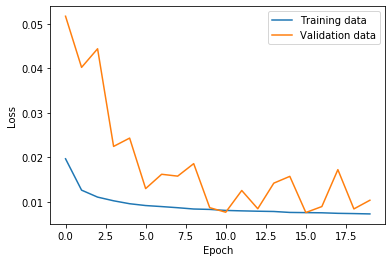

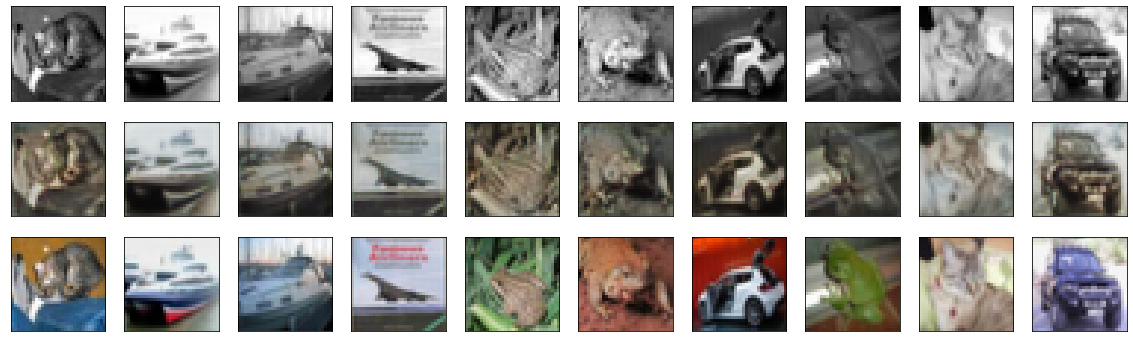

In [5]:

# backend.set_image_data_format('channels_first')

class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1

        def conv(x, n_f, mp_flag=True):
            x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Dropout(0.05)(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        def deconv_unet(x, e, n_f):
            x = UpSampling2D((2, 2))(x)
            x = Concatenate(axis=ic)([x, e])
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            x = Conv2D(n_f, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('tanh')(x)
            return x

        # Input
        original = Input(shape=org_shape)

        # Encoding
        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        # Encoder
        encoded = conv(c2, 64)

        # Decoding
        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
        #decoded = Conv2D(n_ch, (3, 3), padding='same')(x)

        super().__init__(original, decoded)
        self.compile(optimizer=optimizers.Adadelta(learning_rate=1.0), loss='mse')


###########################
# 데이타 불러오기
###########################

class DATA():
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1
        # in_ch can be 1 for changing BW to color image using UNet
        in_ch = n_ch if in_ch is None else in_ch

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:  # "channels_last
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]
            return 0.299 * R + 0.587 * G + 0.114 * B
        
        def RGB2RG(x_train_out, x_test_out, fmt):
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]      
            return x_train_in, x_test_in
        
        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch == 2 and n_ch == 3:
            # print(in_ch, n_ch)
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch


###########################
# UNET 검증
###########################

###########################
# UNET 동작 확인
###########################


def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = unet.predict(x_test_in)
    decoded_imgs = decoded_imgs_org

    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    else:
        # x_test_in = x_test_in[..., 0]
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        if x_test_in.ndim < 4:
            plt.imshow(x_test_in[i], cmap='gray')
        else:
            plt.imshow(x_test_in[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(x_test_out[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def main():
    in_ch = 1
    epochs = 20
    batch_size = 512
    fig=True

    data = DATA(in_ch=in_ch)
    print(data.input_shape, data.x_train_in.shape)
    unet = UNET(data.input_shape, data.n_ch)

    history = unet.fit(data.x_train_in, data.x_train_out,
                       epochs=epochs,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_split=0.2)

    if fig:
        plot_loss(history)
        show_images(data, unet)


if __name__ == '__main__':
    main()